# 1. Imports

In [1]:
# our functions
import functions as f
# readers

import gzip
import json

import codecs

import numpy as np

import random

# plot
import matplotlib.pyplot as plt
import scipy.stats as stats

# NN
## early stopping
import h5py
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# time
from datetime import datetime

In [7]:
PATH = {}
PATH["dataset_classification"] = "dataset/classification/"
PATH["dataset_labeling"] = "dataset/seq_labeling/"
PATH["music_reviews_train"] = PATH["dataset_classification"] + "music_reviews_train.json.gz"
PATH["music_reviews_dev"] = PATH["dataset_classification"] + "music_reviews_dev.json.gz"
PATH["music_reviews_test"] = PATH["dataset_classification"] + "music_reviews_test_masked.json.gz"

# sent dict
sent_dict = {"positive": 1, "negative": 0}

# 2. Read in the files

In [492]:
train = f.readJson(PATH["music_reviews_train"])
dev = f.readJson(PATH["music_reviews_dev"])
test = f.readJson(PATH["music_reviews_test"])
length_of_sentencies_counter = []

Number of data:  100000
Number of data:  10000
Number of data:  10000


## DELETE STOP WORDS

In [498]:
# we need to delete punctuations and some stop words
import string

def remove_stop_words(text):
    my_stop_words = ['$',"'","``","''","'s"]
    whitespace = [' ', '\t', '\n', '\r', '\x0b', '\x0c']
    punct = ['"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~'] # ? ! . are deleted 

    stop_words = set(['heee','i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
    'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
    'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
    'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
    'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
    'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
    'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
    'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
    'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
    'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
    'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
    'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', '\n', 'the', '\x1bthis'] + list(my_stop_words) + list(string.digits) + punct)
    clean_text = []
    length_of_sentencies_counter = []
    for sent in text:
        # add whitespaces between punctuations, etc to be able to remove them
        #print(sent)
        #sent = re.sub('(?<! )(?=[.,!?()])|(?<=[.,!?()])(?! )', r' ', sent)
        sent = re.sub('(?<! )(?=[.,!?()~${}"|#&%*@\'^+-/_0123456789:>`<;=\[\]])|(?<=[.,!?()~${}"|#&%*@\'^+-/_0123456789:>`<;=\[\]])(?! )', r' ', sent)
        #sent = re.sub('([.,!?()])', r' \1 ', sent)
        d_sent = []
        for c in sent.split():
            if c in stop_words:
                None
            else:
                d_sent.append(c)
        clean_text.append(list(d_sent))
        length_of_sentencies_counter.append(len(d_sent))
        #print(d_sent)
    return clean_text,length_of_sentencies_counter #length_of_sentencies_counter

In [507]:
# read the train data
data = train
train_sent = []
train_sentiment = []
train_idx = []
missing_indexies = []
y_train = []
length_of_sentencies_counter = []
for i in range(len(data)):
    try:
        train_sent.append(data[i]["reviewText"])
        train_sentiment.append(data[i]["sentiment"])
        train_idx.append(i)
        y_train.append(sent_dict[data[i]["sentiment"]])
        #length_of_sentencies_counter.append(len(data[i]["reviewText"].split()))
    except KeyError:
        missing_indexies.append(i)
        continue
print(missing_indexies)

########################## remove stop words delet missing shit 
##### ------------- remove stop words
train_sent,length_of_sentencies_counter = remove_stop_words(train_sent)
print("##### ")
empties = []
for i in range(len(train_sent)):
    if len(train_sent[i]) == 0:
        empties.append(i)
c = 0
for i in empties:
    #print(train_sent[i-c])
    del train_sent[i-c]
    del train_sentiment[i-c]
    del y_train[i-c]
    c += 1
    #print(c)

[4603, 4838, 16019, 18229, 19785, 23315, 28397, 28834, 33359, 43138, 43539, 43690, 44008, 44477, 44972, 48811, 49317, 50106, 51717, 52286, 55555, 56171, 57223, 58328, 58799, 58866, 59525, 59739, 61046, 61914, 61916, 62831, 63208, 72268, 78944, 79067, 80093, 80637, 80658, 81640, 81900, 82510, 83138, 83145, 83615, 84761, 87112, 88895, 88984, 89132, 91949, 94301, 94727, 99641]
##### 


3239
0
average number of words in the sentence
32.08572629219778


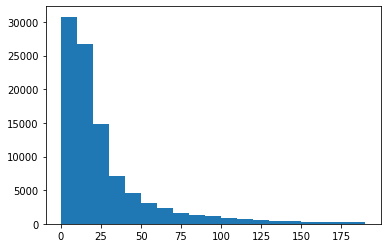

In [502]:
# train data reviews length simple statistic
import matplotlib.pyplot as plt
print(max(length_of_sentencies_counter))
print(min(length_of_sentencies_counter))
bins = [10, 20, 30,40,50,70,80,90,100,150,200,300,400,500,600]
plt.hist(length_of_sentencies_counter, bins = range(0, 200, 10))
print("average number of words in the sentence")
print(np.average(length_of_sentencies_counter))

In [531]:
data = dev
print(len(dev))
dev_sent = []
dev_sentiment = []
dev_idx = []
missing_indexies = []
dev_y_train = []
for i in range(len(data)):
    try:
        dev_sent.append(data[i]["reviewText"])
        dev_sentiment.append(data[i]["sentiment"])
        dev_idx.append(i)
        dev_y_train.append(sent_dict[data[i]["sentiment"]]) 
    except KeyError:
        missing_indexies.append(i)
        continue
print(missing_indexies)

# remove stop words
dev_sent, l = remove_stop_words(dev_sent)

########################## remove stop words delet missing shit 
##### ------------- remove stop words

print("##### ")
empties = []
for i in range(len(dev_sent)):
    if len(dev_sent[i]) == 0:
        empties.append(i)
c = 0
for i in empties:
    #print(train_sent[i-c])
    del dev_sent[i-c]
    del dev_sentiment[i-c]
    del dev_y_train[i-c]
    c += 1
    #print(c)
print(len(dev_sent))
print(len(dev_sentiment))
print(len(dev_y_train))

10000
[2900, 4294, 5135, 8540]
##### 
9984
9984
9984


In [543]:
data = test
test_sent = []
test_sentiment = []
test_idx = []
test_missing_indexies = []
#print(test)
for i in range(len(data)):
    try:
        test_sent.append(data[i]["reviewText"])
        test_sentiment.append(data[i]["sentiment"])
        #print(data[i]["sentiment"])
        test_idx.append(i)
        #y_train.append(sent_dict[data[i]["sentiment"]]) 
    except KeyError:
        test_missing_indexies.append(i)
        continue
print("index of reviews which are empty: ",test_missing_indexies)

# remove stop words
test_sent,l = remove_stop_words(test_sent)

index of reviews which are empty:  [90, 117, 439, 2138, 4112, 5364, 8210]


In [532]:
# it needs to be replaced since it doesnt handle the lower/upper cases and the mess
###################################################################################
from zeugma import TextsToSequences
sequencer = TextsToSequences()

sequencer.fit_transform(train_sent)
# save the sequencer  than load it again
max(sequencer.index_word)
import pickle
b = pickle.dumps(sequencer)
#pickle.dump( b, open( "model/text_to_seq.p", "wb" ) )
pickle.dump( b, open( "model/text_to_seq_without_stop_words.p", "wb" ) )
# load 
#sequencer = pickle.load( open( "model/text_to_seq.p", "rb" ) )
sequencer = pickle.load( open( "model/text_to_seq_without_stop_words.p", "rb" ) )
sequencer = pickle.loads(sequencer)

#print(sequencer.index_word)
# fit new data 
Train = sequencer.transform(train_sent)
Dev = sequencer.transform(dev_sent)
#Test = sequencer.transform(test_sent)

In [394]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [517]:
def sequence_pad(sequence, padding='pre', maxlen=50):
    res = tf.keras.preprocessing.sequence.pad_sequences(
        sequence,
        maxlen=maxlen,
        dtype='int32',
        padding=padding,
        truncating='pre',
        value=0.0)
    return res

## Padding the dataset, POST padding works better a little bit

In [550]:
padding = "post"
maxlen = 60 # how many words from the review
X_train_p = sequence_pad(Train, padding=padding, maxlen=maxlen)
X_dev_p = sequence_pad(Dev, padding=padding, maxlen=maxlen)
X_test_p = sequence_pad(Test, padding=padding, maxlen=maxlen)
len(X_train_p)

99800

In [552]:
X_train_m = np.array(X_train_p)
y_train_m = np.array(y_train)
print(len(y_train_m))
print(len(X_train_m))
X_valid_m = np.array(X_dev_p)
y_valid_m = np.array(dev_y_train)
print(len(X_valid_m))
print(len(y_valid_m))
X_test_m = np.array(X_test_p)
#y_test_m = np.array(y_test)
#print(len(X_test_m))
#print(len(y_test_m))

'''# sampling some random data for tran and DEV
random.seed(40)
bias = 50000

ran = random.randint(0, len(X_train_m)-bias)
ran_val = random.randint(0, len(X_valid_m)-(bias/10))
s_tr = ran
e = ran+bias
s_test = ran_val
e_test = ran_val+(bias/10)

X_train_m = X_train_m[s_tr:e]
y_train_m = y_train_m[s_tr:e]
X_valid_m = X_valid_m[s_test:int(e_test)]
y_valid_m = y_valid_m[s_test:int(e_test)]
#X_valid_m = X_valid_m[s:e]
#y_valid_m = y_valid_m[s:e]'''
print(len(y_train_m))
print(len(X_train_m))

99800
99800
9984
9984
99800
99800


# Early stopping

In [553]:
'''# callback
# https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
#cb = Callback(...)
#cb_list = [cb, ...] # add the callback to a list
es = EarlyStopping(monitor='val_loss',
                  mode='min',
                  verbose=1,
                  patience=1) # to continue since maybe we get a local min somewhere'
                   
# es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1) # other possibility
# es = EarlyStopping(monitor='val_loss', mode='min', baseline=0.4) # based on threshold
# save best models
#mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
#mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1)
checkpoint_filepath = 'model/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                             patience=3,
                                                             mode='min')

# checkpoint

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='min',
    save_best_only=True)'''

"# callback\n# https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/\n#cb = Callback(...)\n#cb_list = [cb, ...] # add the callback to a list\nes = EarlyStopping(monitor='val_loss',\n                  mode='min',\n                  verbose=1,\n                  patience=1) # to continue since maybe we get a local min somewhere'\n                   \n# es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1) # other possibility\n# es = EarlyStopping(monitor='val_loss', mode='min', baseline=0.4) # based on threshold\n# save best models\n#mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)\n#mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1)\ncheckpoint_filepath = 'model/checkpoint'\nmodel_checkpoint_callback = tf.keras.callbacks.EarlyStopping(monitor='loss',\n                                                             patience=3,\n                

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 60, 100)           6852700   
                                                                 
 lstm_15 (LSTM)              (None, 100)               80400     
                                                                 
 dense_15 (Dense)            (None, 1)                 101       
                                                                 
Total params: 6,933,201
Trainable params: 6,933,201
Non-trainable params: 0
_________________________________________________________________
None
200/200 [==============================] - 132s 652ms/step - loss: 0.4008 - accuracy: 0.8111 - val_loss: 0.2714 - val_accuracy: 0.8919


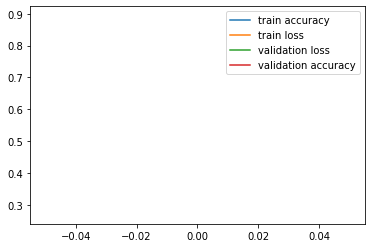

In [568]:
vocabulary_size = max(sequencer.index_word)

from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

# get time for saving the model

dateTimeObj = datetime.now()
save_time = str(dateTimeObj.year)+'-'+str(dateTimeObj.month)+'-'+str(dateTimeObj.day)+'-'+str(dateTimeObj.hour)+'-'+str(dateTimeObj.minute)+'-'+str(dateTimeObj.second)

# define the model

embedding_size=64
embedding_size=100
model=Sequential()
model.add(Embedding(vocabulary_size+1, embedding_size, input_length=maxlen))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])

print(model.summary())

batch_size = 500
num_epochs = 1

#X_valid, y_valid = X_train_k[batch_size:], y_train[batch_size:]
history = model.fit(X_train_m, y_train_m, validation_data=(X_valid_m, y_valid_m), 
                    batch_size=batch_size, 
                    epochs=num_epochs)  # for regularization)
#history = model.fit(X_train_m, y_train_m, batch_size=batch_size, epochs=num_epochs)
#model.fit(X_trainn, y_trainn, batch_size=batch_size, epochs=num_epochs)
#model.fit(X_train_m, y_train_m, batch_size=batch_size, epochs=num_epochs)
#mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
plt.plot(history.history["accuracy"], label='train accuracy')
plt.plot(history.history["loss"], label='train loss')
plt.plot(history.history["val_loss"], label='validation loss')
plt.plot(history.history["val_accuracy"], label='validation accuracy')
plt.legend()
plt.show()
######### ------------------------- ################### save the model
#model.save('model/'+save_time)

In [578]:
model.save('model/'+save_time+"_500_b_size_2_epochs-embed100")

INFO:tensorflow:Assets written to: model/2022-4-1-0-42-57_500_b_size_2_epochs-embed100\assets


INFO:tensorflow:Assets written to: model/2022-4-1-0-42-57_500_b_size_2_epochs-embed100\assets


### Prediction

In [569]:
result = model.predict(X_test_m)

## Sentiment results, Sampling some guess

In [576]:
threshold = 0.5
acc = 0
acc_count = 0
res_final = []
for r in result:
    acc_count+=1
    if r<threshold:
        r = 0
        res_final.append("negative")
    if r>threshold:
        res_final.append("positive")
        
for i in random.sample(range(0, 9993), 5):
    print("index", i)
    print("####", res_final[i], "---", test_sent[i])

index 9385
#### positive --- ['It', 'Wonderful']
index 4047
#### positive --- ['Great', '!', '!']
index 1144
#### positive --- ['Rollerball', 'one', 'top', 'one', 'hundred', 'movies', 'due', 'soundtrack', '.', 'No', 'recording', 'Bach', 'Tocatta', 'Fugue', 'sounds', 'good', 'one', '.']
index 608
#### positive --- ['If', 'looking', 'original', 'slow', 'build', 'middle', 'song', 'right', 'one', '.', 'The', 'song', 'close', 'original', 'build', '.']
index 2435
#### positive --- ['I', 'like', 'upbeat', 'tune', 'isn', 'repetetive', '.', 'I', 'enjoy', 'saxaphone', 'background', 'music', '.', 'Wish', 'I', 'could', 'give', 'stars', 'write', '.']


In [577]:
from collections import defaultdict

json_raw_data = []
jsonfilename = 'dataset/classification/tt.gz'
counter = 0
list_of_skip_indexies = [90, 117, 439, 2138, 4112, 5364, 8210]
res_count = 0
for line in gzip.open('dataset/classification/t_masked.gz'):
    review_data = json.loads(line)
    tempdata = []
    if counter in list_of_skip_indexies: # keep origine
        print("keep original")
        print(counter)
        print(review_data)
        res_count -=1
        for key in review_data:
            #print("keep original")
            tempdata.append({
            key: str(review_data[key])})
    else:
        def_dict = defaultdict(list)
        def_dict = dict()
        for key in review_data:
            #print(key)
            if key == "sentiment":
                def_dict[key] = res_final[res_count]
            else:
                tempdata.append({
                key: str(review_data[key])})
                def_dict[key] = str(review_data[key])
    counter += 1
    res_count +=1
    #print(counter)

    #json_raw_data.append(def_dict)
    json_raw_data.append(def_dict) # ok this is very good, itsa opening with json.load
    
outFile = open('music_reviews_test.json', 'w')
for instance in json_raw_data:
      outFile.write(json.dumps(instance) + '\n')
outFile.close()

keep original
90
{'verified': False, 'reviewTime': '11 16, 2015', 'reviewerID': 'A1O7C6DFZ15E43', 'asin': 'B007Z2OQB0', 'summary': 'Five Stars', 'unixReviewTime': 1447632000, 'sentiment': '_', 'id': 90}
keep original
117
{'verified': True, 'reviewTime': '07 31, 2017', 'reviewerID': 'AWGJYHMXOYCVI', 'asin': 'B007ZCH8R4', 'unixReviewTime': 1501459200, 'sentiment': '_', 'id': 117}
keep original
439
{'verified': True, 'reviewTime': '08 16, 2016', 'reviewerID': 'A24YYQXR82CKHJ', 'asin': 'B008591TBW', 'style': {'Format:': ' MP3 Music'}, 'summary': 'Five Stars', 'unixReviewTime': 1471305600, 'sentiment': '_', 'id': 439}
keep original
2138
{'verified': True, 'reviewTime': '09 13, 2016', 'reviewerID': 'A1ZBIIZLWE8NRE', 'asin': 'B00940XFTK', 'style': {'Format:': ' MP3 Music'}, 'summary': 'Five Stars', 'unixReviewTime': 1473724800, 'sentiment': '_', 'id': 2138}
keep original
4112
{'verified': True, 'reviewTime': '07 4, 2018', 'reviewerID': 'A1K51YDXUGEEBG', 'asin': 'B000YIWSK8', 'unixReviewTime':

In [20]:
for line in gzip.open('group16.json.gz'):
    review_data = json.loads(line)
    for key in review_data:
        print('"' + key +'": ' + str(review_data[key]))
    break

"verified": True
"reviewTime": 10 24, 2017
"reviewerID": A2HAJB8L9NVYTZ
"asin": B007Y1AMHE
"reviewText": ok
"summary": ok
"unixReviewTime": 1508803200
"sentiment": negative
"id": 0
